In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
  0% 0.00/65.2M [00:00<?, ?B/s]
100% 65.2M/65.2M [00:00<00:00, 1.69GB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [5]:
IMG_SIZE = 48
BATCH_SIZE = 64
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test"

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True
)

Found 25841 images belonging to 7 classes.


In [9]:
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=True
)

Found 2868 images belonging to 7 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [11]:
model = Sequential()

model.add(Input(shape=(48, 48, 1)))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [14]:
checkpoint = ModelCheckpoint(
    filepath="best_checkpoint_model.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [15]:
history = model.fit(x=train_generator, epochs=75, validation_data=val_generator,callbacks=[checkpoint, lr_scheduler, early_stopping])

Epoch 1/75


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.1767 - loss: 9.5171
Epoch 1: val_accuracy improved from -inf to 0.13912, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 108ms/step - accuracy: 0.1767 - loss: 9.5155 - val_accuracy: 0.1391 - val_loss: 8.5551 - learning_rate: 1.0000e-04
Epoch 2/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2105 - loss: 8.2941
Epoch 2: val_accuracy improved from 0.13912 to 0.24303, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.2105 - loss: 8.2934 - val_accuracy: 0.2430 - val_loss: 7.2313 - learning_rate: 1.0000e-04
Epoch 3/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2229 - loss: 7.0859
Epoch 3: val_accuracy improved from 0.24303 to 0.24895, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.2229 - loss: 7.0852 - val_accuracy: 0.2490 - val_loss: 6.0392 - learning_rate: 1.0000e-04
Epoch 4/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2332 - loss: 5.9255
Epoch 4: val_accuracy improved from 0.24895 to 0.26499, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.2332 - loss: 5.9249 - val_accuracy: 0.2650 - val_loss: 5.0287 - learning_rate: 1.0000e-04
Epoch 5/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2452 - loss: 4.9130
Epoch 5: val_accuracy improved from 0.26499 to 0.27510, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.2452 - loss: 4.9124 - val_accuracy: 0.2751 - val_loss: 4.2222 - learning_rate: 1.0000e-04
Epoch 6/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2635 - loss: 4.0906
Epoch 6: val_accuracy improved from 0.27510 to 0.30579, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.2636 - loss: 4.0902 - val_accuracy: 0.3058 - val_loss: 3.4940 - learning_rate: 1.0000e-04
Epoch 7/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3033 - loss: 3.4507
Epoch 7: val_accuracy improved from 0.30579 to 0.33543, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.3034 - loss: 3.4503 - val_accuracy: 0.3354 - val_loss: 3.1581 - learning_rate: 1.0000e-04
Epoch 8/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3399 - loss: 2.9635
Epoch 8: val_accuracy improved from 0.33543 to 0.38668, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.3400 - loss: 2.9633 - val_accuracy: 0.3867 - val_loss: 2.6747 - learning_rate: 1.0000e-04
Epoch 9/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3765 - loss: 2.6301
Epoch 9: val_accuracy improved from 0.38668 to 0.42190, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.3765 - loss: 2.6299 - val_accuracy: 0.4219 - val_loss: 2.4989 - learning_rate: 1.0000e-04
Epoch 10/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4082 - loss: 2.3604
Epoch 10: val_accuracy did not improve from 0.42190
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.4082 - loss: 2.3603 - val_accuracy: 0.4006 - val_loss: 2.4351 - learning_rate: 1.0000e-04
Epoch 11/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4365 - loss: 2.1536
Epoch 11: val_accuracy improved from 0.42190 to 0.47141, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.4365 - loss: 2.1535 - val_accuracy: 0.4714 - val_loss: 2.0708 - learning_rate: 1.0000e-04
Epoch 12/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4611 - loss: 2.0090
Epoch 12: val_accuracy improved from 0.47141 to 0.51813, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.4611 - loss: 2.0089 - val_accuracy: 0.5181 - val_loss: 1.8591 - learning_rate: 1.0000e-04
Epoch 13/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4845 - loss: 1.8784
Epoch 13: val_accuracy improved from 0.51813 to 0.52964, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.4845 - loss: 1.8783 - val_accuracy: 0.5296 - val_loss: 1.7480 - learning_rate: 1.0000e-04
Epoch 14/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4999 - loss: 1.8080
Epoch 14: val_accuracy did not improve from 0.52964
404/404 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.4999 - loss: 1.8079 - val_accuracy: 0.5251 - val_loss: 1.7060 - learning_rate: 1.0000e-04
Epoch 15/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5140 - loss: 1.7155
Epoch 15: val_accuracy improved from 0.52964 to 0.54428, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.5140 - loss: 1.7154 - val_accuracy: 0.5443 - val_loss: 1.6342 - learning_rate: 1.0000e-04
Epoch 16/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5283 - loss: 1.6514
Epoch 16: val_accuracy improved from 0.54428 to 0.57008, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.5283 - loss: 1.6514 - val_accuracy: 0.5701 - val_loss: 1.5431 - learning_rate: 1.0000e-04
Epoch 17/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5300 - loss: 1.6203
Epoch 17: val_accuracy did not improve from 0.57008
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.5300 - loss: 1.6203 - val_accuracy: 0.5415 - val_loss: 1.6094 - learning_rate: 1.0000e-04
Epoch 18/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5434 - loss: 1.5753
Epoch 18: val_accuracy did not improve from 0.57008
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.5434 - loss: 1.5753 - val_accuracy: 0.5701 - val_loss: 1.5045 - learning_rate: 1.0000e-04
Epoch 19/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5508 - loss: 1.5466
Epoch 19: val_accuracy did not improve from 0.57008
404/404 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.5508 - loss: 1.5466 - val_accuracy: 0.5603 - val_loss: 1.5161 - learning_rate: 1.0

404/404 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.5591 - loss: 1.5100 - val_accuracy: 0.5969 - val_loss: 1.4263 - learning_rate: 1.0000e-04
Epoch 22/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5650 - loss: 1.4822
Epoch 22: val_accuracy did not improve from 0.59693
404/404 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.5650 - loss: 1.4822 - val_accuracy: 0.5945 - val_loss: 1.4060 - learning_rate: 1.0000e-04
Epoch 23/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5808 - loss: 1.4624
Epoch 23: val_accuracy improved from 0.59693 to 0.60530, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.5808 - loss: 1.4624 - val_accuracy: 0.6053 - val_loss: 1.4088 - learning_rate: 1.0000e-04
Epoch 24/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5771 - loss: 1.4498
Epoch 24: val_accuracy did not improve from 0.60530
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.5771 - loss: 1.4498 - val_accuracy: 0.6053 - val_loss: 1.3832 - learning_rate: 1.0000e-04
Epoch 25/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5832 - loss: 1.4426
Epoch 25: val_accuracy did not improve from 0.60530
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.5832 - loss: 1.4427 - val_accuracy: 0.5886 - val_loss: 1.4125 - learning_rate: 1.0000e-04
Epoch 26/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5869 - loss: 1.4326
Epoch 26: val_accuracy improved from 0.60530 to 0.61053, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.5869 - loss: 1.4326 - val_accuracy: 0.6105 - val_loss: 1.4085 - learning_rate: 1.0000e-04
Epoch 27/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5888 - loss: 1.4250
Epoch 27: val_accuracy did not improve from 0.61053

Epoch 27: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.5888 - loss: 1.4250 - val_accuracy: 0.6004 - val_loss: 1.4086 - learning_rate: 1.0000e-04
Epoch 28/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6010 - loss: 1.3955
Epoch 28: val_accuracy improved from 0.61053 to 0.63494, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6010 - loss: 1.3955 - val_accuracy: 0.6349 - val_loss: 1.3000 - learning_rate: 5.0000e-05
Epoch 29/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6100 - loss: 1.3387
Epoch 29: val_accuracy did not improve from 0.63494
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6100 - loss: 1.3387 - val_accuracy: 0.6301 - val_loss: 1.2904 - learning_rate: 5.0000e-05
Epoch 30/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6094 - loss: 1.3196
Epoch 30: val_accuracy improved from 0.63494 to 0.63877, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.6094 - loss: 1.3196 - val_accuracy: 0.6388 - val_loss: 1.2707 - learning_rate: 5.0000e-05
Epoch 31/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6217 - loss: 1.2932
Epoch 31: val_accuracy did not improve from 0.63877
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6217 - loss: 1.2932 - val_accuracy: 0.6349 - val_loss: 1.2474 - learning_rate: 5.0000e-05
Epoch 32/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6248 - loss: 1.2729
Epoch 32: val_accuracy improved from 0.63877 to 0.64121, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.6248 - loss: 1.2730 - val_accuracy: 0.6412 - val_loss: 1.2506 - learning_rate: 5.0000e-05
Epoch 33/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6228 - loss: 1.2801
Epoch 33: val_accuracy did not improve from 0.64121
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.6228 - loss: 1.2801 - val_accuracy: 0.6241 - val_loss: 1.2644 - learning_rate: 5.0000e-05
Epoch 34/75
403/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6264 - loss: 1.2649
Epoch 34: val_accuracy improved from 0.64121 to 0.64714, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6263 - loss: 1.2649 - val_accuracy: 0.6471 - val_loss: 1.2228 - learning_rate: 5.0000e-05
Epoch 35/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6318 - loss: 1.2569
Epoch 35: val_accuracy did not improve from 0.64714
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.6318 - loss: 1.2569 - val_accuracy: 0.6332 - val_loss: 1.2367 - learning_rate: 5.0000e-05
Epoch 36/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6280 - loss: 1.2447
Epoch 36: val_accuracy did not improve from 0.64714
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.6280 - loss: 1.2447 - val_accuracy: 0.6391 - val_loss: 1.2223 - learning_rate: 5.0000e-05
Epoch 37/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6358 - loss: 1.2409
Epoch 37: val_accuracy did not improve from 0.64714
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.6358 - loss: 1.2409 - val_accuracy: 0.6311 - val_loss: 1.2506 - learning_rate: 5.0

404/404 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.6529 - loss: 1.1932 - val_accuracy: 0.6660 - val_loss: 1.1675 - learning_rate: 2.5000e-05
Epoch 43/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6627 - loss: 1.1677
Epoch 43: val_accuracy did not improve from 0.66597
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6627 - loss: 1.1677 - val_accuracy: 0.6597 - val_loss: 1.1680 - learning_rate: 2.5000e-05
Epoch 44/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6604 - loss: 1.1647
Epoch 44: val_accuracy did not improve from 0.66597
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6604 - loss: 1.1647 - val_accuracy: 0.6541 - val_loss: 1.1795 - learning_rate: 2.5000e-05
Epoch 45/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6622 - loss: 1.1481
Epoch 45: val_accuracy did not improve from 0.66597
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6622 - loss: 1.1481 - val_accuracy: 0.6545 - val_loss: 1.1632 - learning_rate: 2.5

404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6707 - loss: 1.1124 - val_accuracy: 0.6729 - val_loss: 1.1406 - learning_rate: 2.5000e-05
Epoch 49/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6733 - loss: 1.1150
Epoch 49: val_accuracy did not improve from 0.67294
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.6733 - loss: 1.1150 - val_accuracy: 0.6635 - val_loss: 1.1444 - learning_rate: 2.5000e-05
Epoch 50/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6723 - loss: 1.1046
Epoch 50: val_accuracy did not improve from 0.67294
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.6723 - loss: 1.1046 - val_accuracy: 0.6684 - val_loss: 1.1311 - learning_rate: 2.5000e-05
Epoch 51/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6762 - loss: 1.1089
Epoch 51: val_accuracy did not improve from 0.67294
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.6762 - loss: 1.1089 - val_accuracy: 0.6691 - val_loss: 1.1258 - learning_rate: 2.5

404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6923 - loss: 1.0279 - val_accuracy: 0.6806 - val_loss: 1.0961 - learning_rate: 6.2500e-06
Epoch 60/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6994 - loss: 1.0287
Epoch 60: val_accuracy did not improve from 0.68061
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6994 - loss: 1.0287 - val_accuracy: 0.6736 - val_loss: 1.1063 - learning_rate: 6.2500e-06
Epoch 61/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7048 - loss: 1.0168
Epoch 61: val_accuracy improved from 0.68061 to 0.68480, saving model to best_checkpoint_model.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.7048 - loss: 1.0168 - val_accuracy: 0.6848 - val_loss: 1.0971 - learning_rate: 6.2500e-06
Epoch 62/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6972 - loss: 1.0220
Epoch 62: val_accuracy did not improve from 0.68480
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6972 - loss: 1.0220 - val_accuracy: 0.6796 - val_loss: 1.0944 - learning_rate: 6.2500e-06
Epoch 63/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6961 - loss: 1.0211
Epoch 63: val_accuracy did not improve from 0.68480
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6961 - loss: 1.0211 - val_accuracy: 0.6705 - val_loss: 1.1070 - learning_rate: 6.2500e-06
Epoch 64/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7081 - loss: 1.0132
Epoch 64: val_accuracy did not improve from 0.68480
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.7081 - loss: 1.0132 - val_accuracy: 0.6799 - val_loss: 1.0917 - learning_rate: 6.2

404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.7012 - loss: 1.0069 - val_accuracy: 0.6911 - val_loss: 1.0719 - learning_rate: 3.1250e-06
Epoch 70/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7080 - loss: 0.9847
Epoch 70: val_accuracy did not improve from 0.69107
404/404 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.7080 - loss: 0.9847 - val_accuracy: 0.6834 - val_loss: 1.0872 - learning_rate: 3.1250e-06
Epoch 71/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7050 - loss: 1.0012
Epoch 71: val_accuracy did not improve from 0.69107
404/404 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.7050 - loss: 1.0011 - val_accuracy: 0.6817 - val_loss: 1.0862 - learning_rate: 3.1250e-06
Epoch 72/75
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7040 - loss: 0.9956
Epoch 72: val_accuracy did not improve from 0.69107

Epoch 72: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.7040 

In [19]:
import matplotlib.pyplot as plt

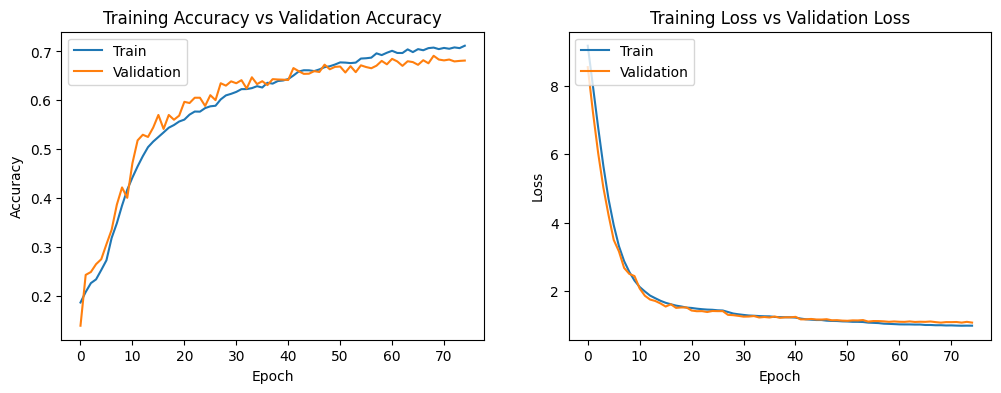

In [33]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [24]:
model.save("model_optimal.h5")

In [32]:
model.save_weights('model_optimal.weights.h5')